In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


test = pd.read_csv('data_test.csv')
train = pd.read_csv('data_train.csv')

## dropfirst column "Unnamed: 0"
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)

# Drop the Loan_ID column
train = train.drop('Loan_ID', axis=1)
test = test.drop('Loan_ID', axis=1)


# Describing the data
print(train.head())
print(train.shape)
## check for null values
print(train.isnull().sum())
#drop null
train = train.dropna()
print(train.shape)

# randomly split into data into training
# and validation sets
np.random.seed(0)
# randomly shuffle the data
train = train.sample(frac=1)
# 80% of the data will be used for training
train_size = int(0.8 * train.shape[0])

train_data = train.iloc[:train_size]
val_data = train.iloc[train_size:]

y_train , y_val = train_data['Loan_Status'], val_data['Loan_Status']
x_train, x_val = train_data.drop('Loan_Status', axis=1), val_data.drop('Loan_Status', axis=1)

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

print(x_val.head())

  Gender Married Dependents Education Self_Employed  ApplicantIncome  \
0   Male     Yes          1  Graduate            No             1538   
1   Male     Yes          0  Graduate            No             6133   
2   Male      No          0  Graduate            No             4680   
3   Male     Yes          2  Graduate            No             3859   
4   Male     Yes          2  Graduate           NaN             5000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0             1425.0        30.0             360.0             1.0   
1             3906.0       324.0             360.0             1.0   
2             2087.0         NaN             360.0             1.0   
3                0.0        96.0             360.0             1.0   
4                0.0        72.0             360.0             0.0   

  Property_Area Loan_Status  
0         Urban           Y  
1         Urban           Y  
2     Semiurban           N  
3     Semiurban           

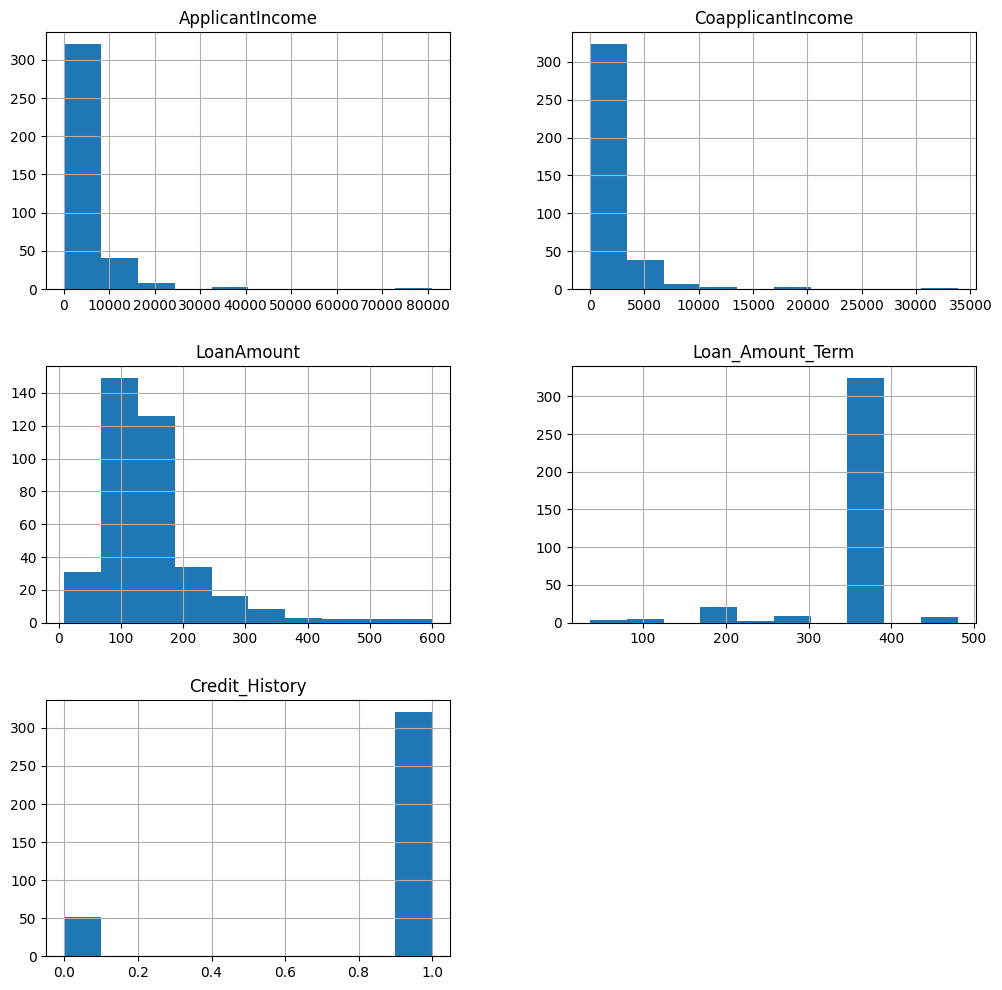

In [40]:
# Histograms of data
train.hist(figsize=(12, 12))
plt.show()

In [45]:
#implement decision tree
from collections import defaultdict
class Node:
    def __init__(self, predicted_class = None):
        self.predicted_class = predicted_class
        self.category = None
        self.threshold = 0
        self.children = {}

class DecisionTree:
    
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None
    def fit(self, X, y):
        self.root = self._fit(X, y)
    def _fit(self, X, y, depth=0):
        if len(set(y)) == 1:
            return Node(y.iloc[0])  # Access first element by position

        if self.max_depth is not None and depth == self.max_depth:
            res = Node(y.mode()[0]) 
            return res

        best_gini = float('inf')
        best_col = None
        
        # Find the best column with the lowest gini impurity
        for col in X.columns:
            gini, value = self.gini_impurity(X[col], y)
            if gini < best_gini:
                best_gini = gini
                best_col = col
                best_value = value

        if pd.api.types.is_categorical_dtype(X[best_col]) or pd.api.types.is_object_dtype(X[best_col]):
            root = Node()
            root.category = best_col
            for val in best_value:
                X_filtered = X[X[best_col] == val]
                y_filtered = y.loc[X_filtered.index]  # Align indices
                root.children[val] = self._fit(X_filtered, y_filtered, depth + 1)
        else:
            root = Node()
            root.threshold = best_value
            root.category = best_col
            
            X_left = X[X[best_col] < best_value]
            X_right = X[X[best_col] >= best_value]

            y_left = y.loc[X_left.index]  # Align indices
            y_right = y.loc[X_right.index]  # Align indices

            root.children['left'] = self._fit(X_left, y_left, depth + 1)
            root.children['right'] = self._fit(X_right, y_right, depth + 1)

        return root
    def predict(self, X):
        # Apply the prediction for each row of X
        return X.apply(lambda row: self._predict(row, self.root), axis=1)

    def _predict(self, X_row, node):
        # If the node is a leaf node, return the predicted class
        if node.predicted_class is not None:
            return node.predicted_class
        
        # Check if the feature value for this row is less than the threshold (for numeric columns)
        def _predict(self, X_row, node):
            # If the node is a leaf node, return the predicted class
            if node.predicted_class is not None:
                return node.predicted_class

            # Check if the feature value for this row is less than the threshold (for numeric columns)
            if isinstance(node.threshold, (int, float)):
                # Ensure the comparison only happens for numeric data
                if pd.api.types.is_numeric_dtype(X_row[node.category]):
                    if X_row[node.category] < node.threshold:
                        return self._predict(X_row, node.children['left'])
                    else:
                        return self._predict(X_row, node.children['right'])
            else:
                # For categorical columns, look up the correct child node
                return self._predict(X_row, node.children[X_row[node.category]])



        
    '''Gini returns the gini of a particulat column as well as the split point if it is continuous or tje categories if it is categorical'''
    def gini_impurity(self, x_col : pd.DataFrame, y : pd.DataFrame):
        ## determine if the x_col is continuous or categorical
        if x_col.dtype == 'object':
            categories = x_col.unique()
            gini = 0
            ## if categorical
            for c in categories:
                respones = defaultdict(int)
                
                # temp stores the index of the rows where x_col == c
                temp = y[x_col == c]
                for t in temp:
                    respones[t] += 1
                gini += (1 - sum([(respones[r]/len(temp))**2 for r in respones])) * len(temp)/len(y)
            return gini, categories
            
            ## find the unique values of x_col
            ## for each unique value, calculate the gini impurity
            ## return the sum of the gini impurities
            pass
        else:
            ## if continuous
            ## sort the x_col
            x_col_sorted = x_col.sort_values()
            x_col_sorted = x_col.sort_values().reset_index(drop=True)
            averages = []
            for i in range(1, len(x_col_sorted)):
                averages.append((x_col_sorted[i] + x_col_sorted[i-1])/2)
                
            best_gini = float('inf')
            best_avg = None
            ## calc gini for each average
            for a in averages:
                gini = 0
                left_responses = defaultdict(int)
                right_responses = defaultdict(int)
                
                left_temp = y[x_col < a]
                right_temp = y[x_col >= a]
                
                # Calculate left side Gini
                for t in left_temp:
                    left_responses[t] += 1
                gini_left = (1 - sum([(left_responses[r]/len(left_temp))**2 for r in left_responses])) * len(left_temp)/len(y)
                
                # Calculate right side Gini
                for t in right_temp:
                    right_responses[t] += 1
                gini_right = (1 - sum([(right_responses[r]/len(right_temp))**2 for r in right_responses])) * len(right_temp)/len(y)
                
                gini = gini_left + gini_right
                
                if gini < best_gini:
                    best_gini = gini
                    best_avg = a
            return best_gini, best_avg
            

        
        
    
        

In [50]:
#test
tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)
pred = tree.predict(x_val)
print(pred.head())


/var/folders/30/nqp_2f3d38g7cj28w_nf1rhm0000gn/T/ipykernel_63658/2513922007.py:35: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[best_col]) or pd.api.types.is_object_dtype(X[best_col]):
/var/folders/30/nqp_2f3d38g7cj28w_nf1rhm0000gn/T/ipykernel_63658/2513922007.py:35: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[best_col]) or pd.api.types.is_object_dtype(X[best_col]):
/var/folders/30/nqp_2f3d38g7cj28w_nf1rhm0000gn/T/ipykernel_63658/2513922007.py:35: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[best_col]) or pd.api.types.is_object_dtype(X[best_col]):
/var/folders/30/